<a href="https://colab.research.google.com/github/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_compare_protein_and_gene_expression_CPTAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to compare protein and gene expression in the CPTAC dataset

```
Title:   How to compare protein and gene expression in the CPTAC dataset
Author:  Boris Aguilar
Created: 06-21-2021
Purpose: Retrieve protein and gene expression from the CPTAC BigQuery tables and visualize the data 
Notes: Runs in Google Colab   
```
This notebook uses BigQuery to retrieve protein and gene expression for given gene in the CPTAC dataset. Scatter plots are then generated to compare these two types of data.

For this example we used Clear cell renal cell carcinoma (CCRCC). Other cancer types can be easily used.

## Modules

In [20]:
from google.cloud import bigquery
from google.colab import auth
import pandas as pd
import seaborn as sns
import pandas_gbq

## Google Authentication
The first step is to authorize access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html) and alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

Moreover you need to [create a google cloud](https://cloud.google.com/resource-manager/docs/creating-managing-projects#console) project to be able to run BigQuery queries.

In [21]:
auth.authenticate_user()
my_project_id = "" # write your project id here
bqclient = bigquery.Client( my_project_id )

## Parameters
For this experiments we need to setup the gene name, the name of the table with protein expression data for CCRCC (for other cancer types one needs to change this table name), and the name of the table with gene expression data.

In [12]:
gene_name = 'RAB5A'
protein_table = 'isb-cgc-bq.CPTAC.quant_proteome_CPTAC_CCRCC_discovery_study_pdc_current'
gexp_table = 'isb-cgc-bq.CPTAC.RNAseq_hg38_gdc_current'

## Retrieve protein expression of CCRCC

The following query will retrieve protein expression and case IDs from the given CPTAC table. Moreover, to label samples as Tumor or Normal samples we join the table with metadata available in the table `aliquot_to_case_mapping_pdc_current`.

In [13]:
prot = '''quant AS (
    SELECT meta.sample_submitter_id, meta.sample_type, quant.case_id, quant.aliquot_id, quant.gene_symbol, 
           CAST(quant.protein_abundance_log2ratio AS FLOAT64) AS protein_abundance_log2ratio 
    FROM `{0}` as quant
    JOIN `isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current` as meta
        ON quant.case_id = meta.case_id
        AND quant.aliquot_id = meta.aliquot_id
        AND quant.gene_symbol = '{1}'
)
'''.format(protein_table,gene_name)

## Retrieve gene expression of CCRCC
Next we retrieve gene expression data from the table `CPTAC.RNAseq_hg38_gdc_current` which contains RNA-seq data from all tumor types of CPTAC. Moreover we join the data with the metadata table `aliquot_to_case_mapping_pdc_current` to label samples as cancer or normal tissue.

In [14]:
gexp = '''gexp AS (
    SELECT DISTINCT meta.sample_submitter_id, meta.sample_type, rnaseq.gene_name , LOG(rnaseq.HTSeq__FPKM + 1) as HTSeq__FPKM   
    FROM `{0}` as rnaseq
    JOIN `isb-cgc-bq.PDC_metadata.aliquot_to_case_mapping_current` as meta
        ON meta.sample_submitter_id = rnaseq.sample_barcode
        AND rnaseq.gene_name = '{1}'
)
'''.format(gexp_table, gene_name)

## Run the query to retrieve the data

In [19]:
mysql = ( 'WITH ' + prot + ',' + gexp + 
'''
SELECT quant.sample_submitter_id, quant.sample_type, quant.gene_symbol, 
       quant.protein_abundance_log2ratio, gexp.HTSeq__FPKM
FROM quant
JOIN gexp 
ON gexp.sample_submitter_id = quant.sample_submitter_id
'''    )

df2 = pandas_gbq.read_gbq(mysql,project_id=my_project_id )
df2[0:10]

Downloading: 100%|██████████| 175/175 [00:00<00:00, 847.19rows/s]


,sample_submitter_id,sample_type,gene_symbol,protein_abundance_log2ratio,HTSeq__FPKM
0,C3N-00494-05,Solid Tissue Normal,RAB5A,-0.0237,2.854013
1,C3L-00011-01,Primary Tumor,RAB5A,-0.0956,2.768813
2,C3N-01261-06,Solid Tissue Normal,RAB5A,0.3311,2.779552
3,C3L-01287-02,Primary Tumor,RAB5A,-0.1559,2.621475
4,C3N-00852-06,Solid Tissue Normal,RAB5A,-0.1130,2.932494
5,C3L-01607-06,Solid Tissue Normal,RAB5A,-0.3805,2.866062
6,C3L-01836-02,Primary Tumor,RAB5A,-0.4295,2.404121
7,C3L-01302-03,Primary Tumor,RAB5A,-0.3248,2.495302
8,C3N-00244-06,Solid Tissue Normal,RAB5A,0.3032,2.679795
9,C3L-00907-06,Solid Tissue Normal,RAB5A,0.1733,2.773120


## Generate scatter plot
The following commands generate scatter plots to compare the protein (y axis) and gene (x axis) expression for a given gene. Two scatter plots are generated, one for cancer samples (Primary Tumor) and other for normal tissue samples (Solid Tissue Normal).

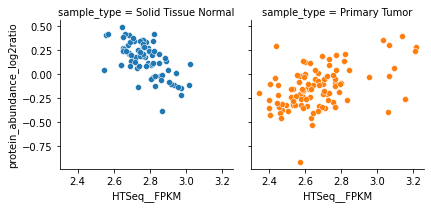

In [18]:
grid = sns.FacetGrid(df2, col = "sample_type", hue = "sample_type", col_wrap=2)
grid.map(sns.scatterplot, "HTSeq__FPKM", "protein_abundance_log2ratio")